In [1]:
!pip install accelerate -U

In [ ]:
## Restart the runtime after installing accelerate(In Colab)

In [ ]:
!pip install transformers
!pip install appdirs
!pip install bitsandbytes
!pip install datasets
!pip install fire
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torch
!pip install sentencepiece
!pip install tensorboardX
!pip install gradio


In [2]:
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import sys
from typing import List

In [3]:
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

In [4]:
import fire
import torch
from datasets import load_dataset
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams

In [6]:
%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
DEVICE

'cuda'

### Data, Data, & Data

In [9]:
!gdown 1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN

Downloading...
From: https://drive.google.com/uc?id=1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN
To: /content/bitcoin-sentiment-tweets.csv
100% 242k/242k [00:00<00:00, 110MB/s]


In [10]:
df = pd.read_csv("/content/bitcoin-sentiment-tweets.csv")
df.head()

,date,tweet,sentiment
0,Fri Mar 23 00:40:40 +0000 2018,@p0nd3ea Bitcoin wasn't built to live on excha...,1.0
1,Fri Mar 23 00:40:40 +0000 2018,@historyinflicks Buddy if I had whatever serie...,1.0
2,Fri Mar 23 00:40:42 +0000 2018,@eatBCH @Bitcoin @signalapp @myWickr @Samsung ...,0.0
3,Fri Mar 23 00:41:04 +0000 2018,@aantonop Even if Bitcoin crash tomorrow morni...,0.0
4,Fri Mar 23 00:41:07 +0000 2018,I am experimenting whether I can live only wit...,1.0


In [11]:
df.sentiment.value_counts()

 0.0    860
 1.0    779
-1.0    258
Name: sentiment, dtype: int64

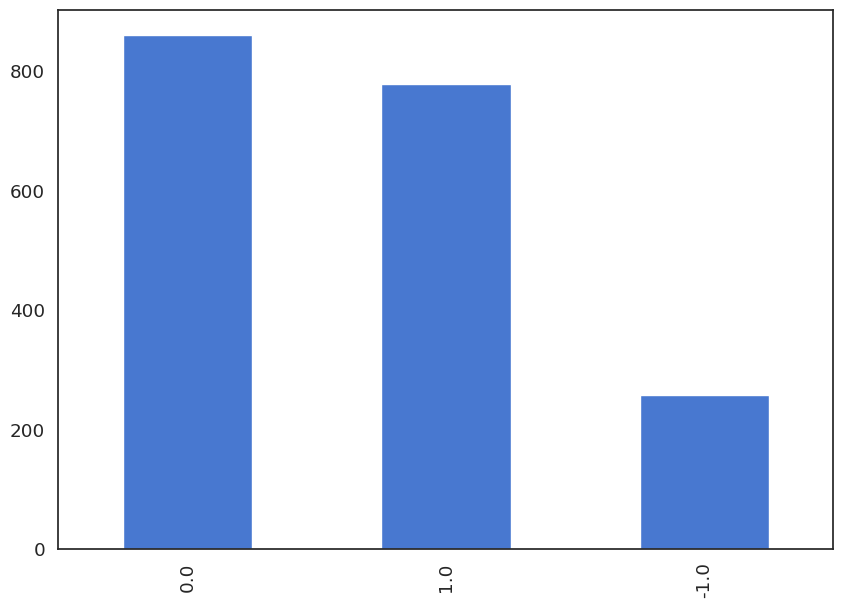

In [12]:
df.sentiment.value_counts().plot(kind='bar');

### Building JSON Dataset

In [13]:
# helper function
def sentiment_score_to_name(score: float):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    return "Neutral"

In [14]:
dataset_data = [
    {
        "instruction": "Detect the sentiment of the tweet.",
        "input": row_dict["tweet"],
        "output": sentiment_score_to_name(row_dict["sentiment"])
    }
    for row_dict in df.to_dict(orient="records")
]

In [15]:
dataset_data[0]

{'instruction': 'Detect the sentiment of the tweet.',
 'input': "@p0nd3ea Bitcoin wasn't built to live on exchanges.",
 'output': 'Positive'}

In [16]:
import json
with open("alpaca-bitcoin-sentiment-dataset.json", "w") as f:
   json.dump(dataset_data, f)

### Model Weights

In [17]:
BASE_MODEL = "decapoda-research/llama-7b-hf"

In [18]:
model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [19]:
tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [20]:
tokenizer.pad_token_id = (
    0  # unk. we want this to be different from the eos token
)

In [21]:
tokenizer.padding_side = "left"

### Dataset

In [22]:
data = load_dataset("json", data_files="alpaca-bitcoin-sentiment-dataset.json")
data["train"]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-aba1195fbdd14194/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['input', 'instruction', 'output'],
    num_rows: 1897
})

In [24]:
def generate_prompt(data_point):
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""


In [29]:
CUTOFF_LEN = 256

In [30]:
def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

In [26]:
def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [27]:
train_val = data["train"].train_test_split(
    test_size=200, shuffle=True, seed=42
)

In [31]:
train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)

Map:   0%|          | 0/1697 [00:00<?, ? examples/s]

In [32]:
val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

### Training

In [33]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]

In [34]:
BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 300
OUTPUT_DIR = "/content/experiments"

In [35]:
model = prepare_model_for_int8_training(model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


In [36]:
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)

In [37]:
model = get_peft_model(model, config)

In [38]:
model.print_trainable_parameters()

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


In [39]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

In [40]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

In [41]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)

In [42]:
model.config.use_cache = False
old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))

In [43]:
model = torch.compile(model)

In [47]:
model = model.to(DEVICE)

In [48]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
model.save_pretrained(OUTPUT_DIR)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

model.push_to_hub("yourname/alpaca-bitcoin-tweets-sentiment", use_auth_token=True)